# 4. PyTorch custom datasets

## 0. Importing torch and setting up device agnostic code.

In [ ]:
import torch
from torch import nn
torch.__version__

'2.1.0+cu121'

In [ ]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

Our dataset is a subset of the Food101 dataset.

Food101 starts with 101 different classes of food and 1000 images per class (750 training, 250 testing)

Our dataset starts with 3 classes and only 10% of the images (~75 training, 25 testing).

Why do this ?

When starting out with ML projects, it's important to try things on a small scale and increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [ ]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
# print(image_path)

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} directory does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download Pizza, steak, and sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping Pizza, steak, and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory does not exist, creating one...
Unzipping Pizza, steak, and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [ ]:
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dir_path}'.")

In [ ]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi'.


In [ ]:
# Setup train and test paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visulaizing an Image

Let's write some code to:

1. Get all of the image paths.
2. Pick a random image path using python's `random.choice()`
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python's PIL.
5. We'll then show the image and print metadata.

Random image path: data/pizza_steak_sushi/test/steak/296375.jpg
Image class: steak
Image height: 512
Image width: 382


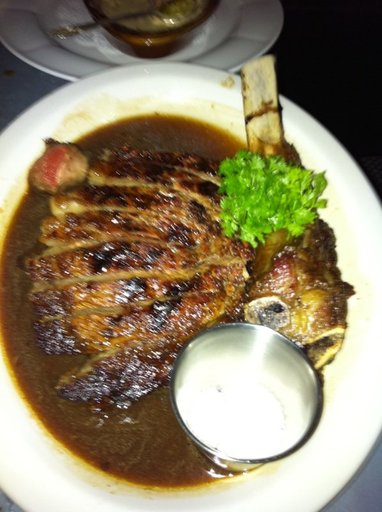

In [ ]:
import random
from PIL import Image

# Set seed
random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob('*/*/*.jpg'))

# 2. Pick a random image
random_image_path = random.choice(image_path_list)

# 3. Get the image class name (image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open the image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

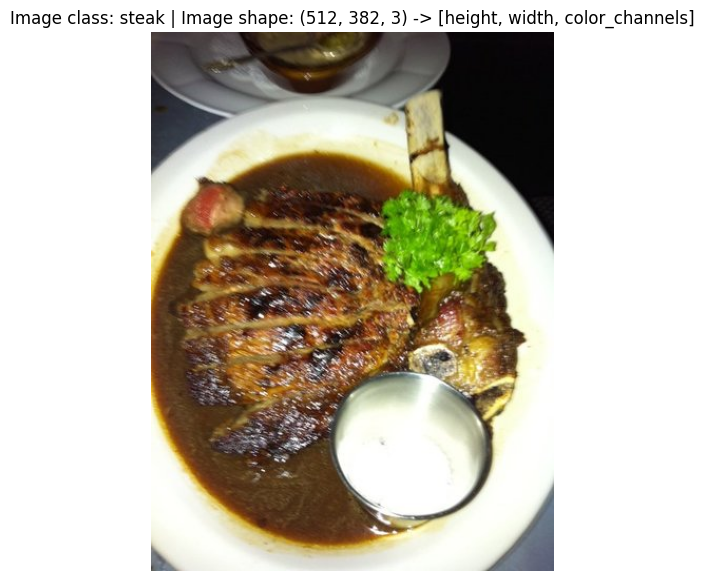

In [ ]:
# Visualize images using matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## 3. Transforming Data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors.
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [ ]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [ ]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5),
    # Turn the image into a torch.Tensor
    transforms.ToTensor()
])

In [ ]:
data_transform(img)

tensor([[[0.0431, 0.0431, 0.0431,  ..., 0.2627, 0.2784, 0.2941],
         [0.0392, 0.0392, 0.0392,  ..., 0.2549, 0.2627, 0.2824],
         [0.0314, 0.0314, 0.0275,  ..., 0.2745, 0.2706, 0.2745],
         ...,
         [0.3765, 0.3882, 0.3961,  ..., 0.9294, 0.8196, 0.6275],
         [0.3608, 0.3725, 0.3843,  ..., 0.7412, 0.5176, 0.4627],
         [0.3529, 0.3647, 0.3725,  ..., 0.5059, 0.4353, 0.4157]],

        [[0.0235, 0.0235, 0.0235,  ..., 0.2275, 0.2392, 0.2549],
         [0.0235, 0.0235, 0.0235,  ..., 0.2196, 0.2235, 0.2431],
         [0.0196, 0.0235, 0.0196,  ..., 0.2392, 0.2392, 0.2392],
         ...,
         [0.4000, 0.4118, 0.4196,  ..., 0.9255, 0.8157, 0.6275],
         [0.3882, 0.3961, 0.4039,  ..., 0.7333, 0.5176, 0.4745],
         [0.3804, 0.3882, 0.3922,  ..., 0.5255, 0.4667, 0.4353]],

        [[0.0392, 0.0392, 0.0392,  ..., 0.2431, 0.2431, 0.2431],
         [0.0392, 0.0353, 0.0353,  ..., 0.2392, 0.2353, 0.2431],
         [0.0314, 0.0353, 0.0314,  ..., 0.2549, 0.2471, 0.

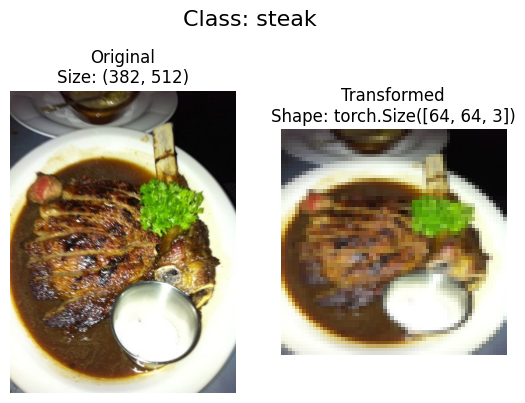

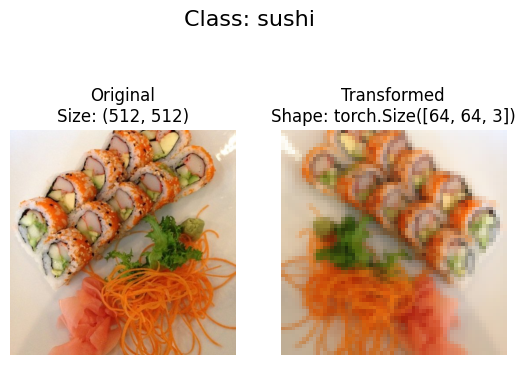

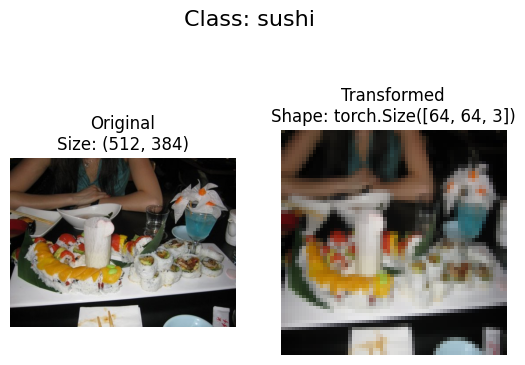

In [ ]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
  """
  Selects random images from a path of images and loads/transforms
  them then plots the original vs the transformed version.
  """
  if seed:
    random.seed(seed)

  random_image_paths = random.sample(image_paths, k=n)

  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1, 2, 0) # Note: We will need to change shape for matplotlib (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, data_transform, 3, seed=42)

## 4. Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder`

In [ ]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # a transform for the data
                                  target_transform=None) # a transform for the target/label

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=warn)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [ ]:
# Get class names as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [ ]:
# Get class names as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [ ]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [ ]:
# Index on the train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1] # You can also do img, label = train_data[0]
print(f"Image tensor: {img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image Label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor: tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'pizza')

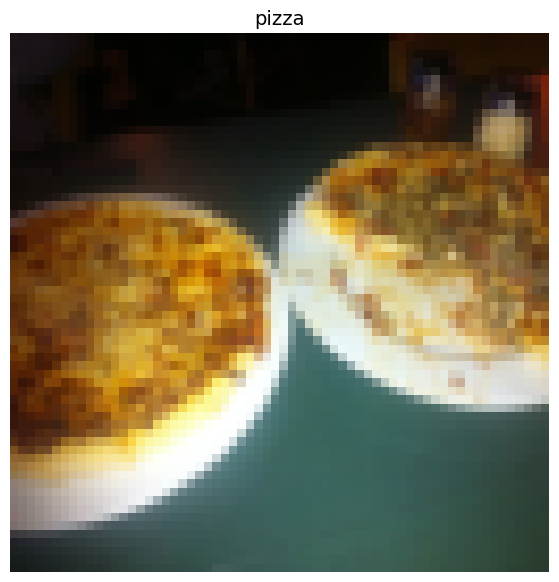

In [ ]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis(False)
plt.title(class_names[label], fontsize=14)

In [ ]:
class_names[label]

'pizza'

## 4.1 Turn loaded images into `DataLoader`'s

A `DataLoader` is going to help us turn our `Dataset`'s into iterables and we can customize the `batch_size` so our model can see `batch_size` images at a time.


In [ ]:
import os
os.cpu_count()

2

In [ ]:
# Turn the train and test dataset's into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 1

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=1) # How many cores do you want to load your data

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False,
                             num_workers=1)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7fb470408d00>,
 <torch.utils.data.dataloader.DataLoader at 0x7fb470408550>)

In [ ]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [ ]:
img, label = next(iter(train_dataloader))

print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image data with a Custom `Dataset`

1. Want to be able to load images from file.
2. Want to be able to get class names from the Dataset.
3. Want to be able to get classes as dictionaries from the Dataset.

Pros:

* Can create a `Datastet` out of almost anything.
* Not limited to PyTorch pre-built `Dataset` functions.

Cons:

*  Even though you could create a `Dataset` almost out of anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues.

In [ ]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [ ]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [ ]:
# Setup path for target directory
target_dir = train_dir
print(f"Target directory: {target_dir}")

# Get the class names from the target_dir
class_names_found = sorted([entry.name for entry in list(os.scandir(target_dir))])
class_names_found

Target directory: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [ ]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """Finds the class folder names in a target directory."""
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names could not be found.
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")

  # 3. Create a dictionary of index labels (computers prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}

  return classes, class_to_idx

In [ ]:
find_classes(target_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.data.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of our images.
  * transform - the transform we'd like to use.
  * classes - a list of target classes.
  * class_to_idx - a dict of the target classes mapped to target labels.
4. Create a function to `load_images()`, this function will open an image.
5. Overwrite the `__len()__` method to return the length of our dataset.
6. Overwrite the `__getitem()__` method to return a given sample when passed an index.

In [ ]:
# 0. Write a custom Dataset
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):
  # 2. Initialize our custom dataset
  def __init__(self,
               targ_dir: str,
               transform: None):
    # 3. Create class attributes
    # Get all of the image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg"))
    # Setup transform
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Create a function to load images.
  def load_image(self, index:int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]
    return Image.open(image_path)

  # 5. Overwrite __len__()
  def __len__(self) -> int:
    "Return the total number of samples."
    return len(self.paths)

  # 6. Overwrite __getitem__() method to return a particular sample
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx # return image and label

In [ ]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [ ]:
# Test our ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir,
                                     transform=test_transforms)

train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7fb4703946a0>,
 <__main__.ImageFolderCustom at 0x7fb470434820>)

In [ ]:
len(train_data), len(train_data_custom)

(225, 225)

In [ ]:
len(test_data), len(test_data_custom)

(75, 75)

In [ ]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [ ]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}